## Part 1: Supervised Baseline (Feedforward Network)
**Project**: FraudGuard - Credit Card Fraud Detection 

**Goal**: Establish a strong supervised benchmark using Weighted Loss and Threshold Optimization.

## 1. Setup and Exploratory Data Analysis (EDA)
**Objective**: Understand the data distribution and justify preprocessing decisions.

Using device: cpu
Dataset Loaded. Shape: (284807, 31)


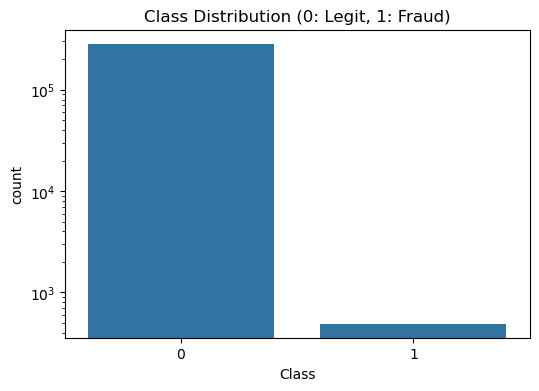

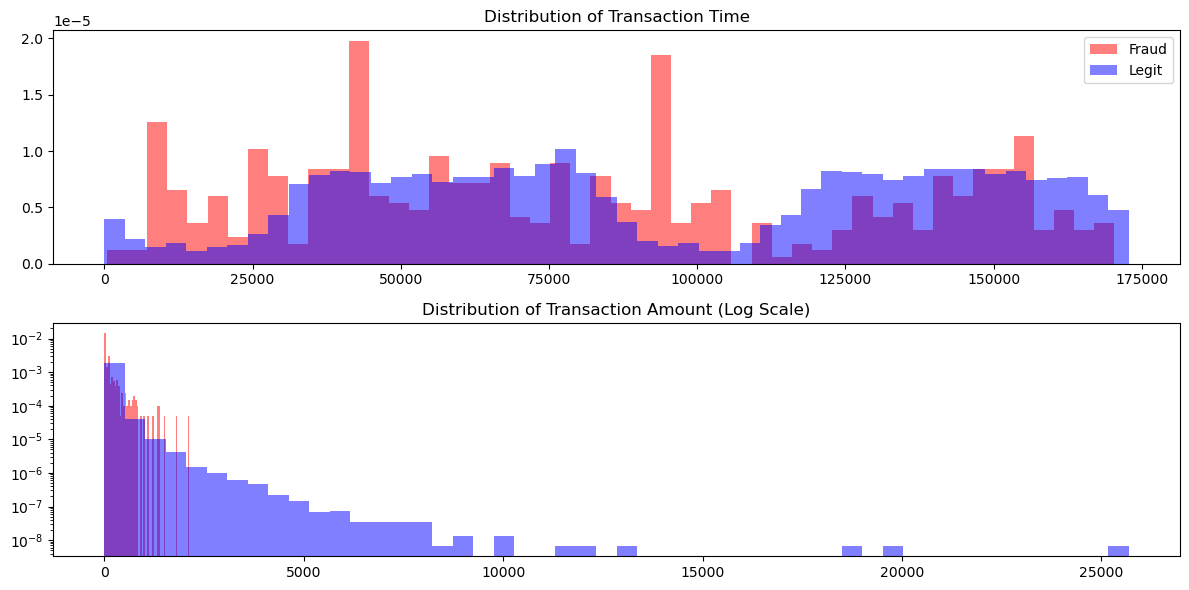

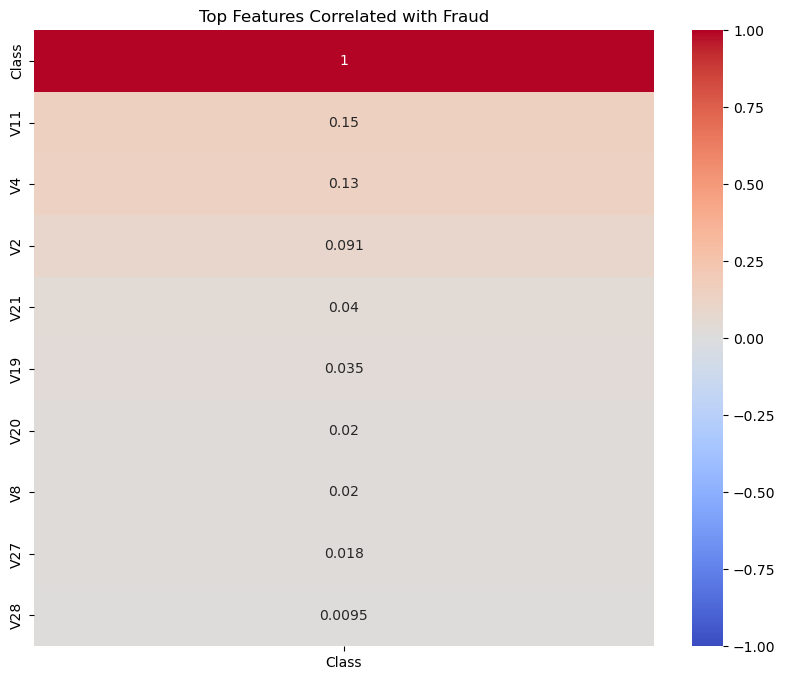

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Load Data ---
try:
    df = pd.read_csv('creditcard.csv')
    print(f"Dataset Loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found.")

# --- 2. EDA: Class Imbalance ---
# Rationale: Visualizing the <0.2% fraud rate to justify Weighted Loss.
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Legit, 1: Fraud)')
plt.yscale('log') # Log scale is crucial here
plt.show()

# --- 3. EDA: Feature Distributions ---
# Rationale: Checking if 'Time' and 'Amount' need scaling.
f, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(12, 6))
bins = 50

ax1.hist(df.Time[df.Class == 1], bins=bins, color='red', alpha=0.5, density=True, label='Fraud')
ax1.hist(df.Time[df.Class == 0], bins=bins, color='blue', alpha=0.5, density=True, label='Legit')
ax1.set_title('Distribution of Transaction Time')
ax1.legend()

ax2.hist(df.Amount[df.Class == 1], bins=bins, color='red', alpha=0.5, density=True, label='Fraud')
ax2.hist(df.Amount[df.Class == 0], bins=bins, color='blue', alpha=0.5, density=True, label='Legit')
ax2.set_title('Distribution of Transaction Amount (Log Scale)')
ax2.set_yscale('log')
plt.tight_layout()
plt.show()

# --- 4. EDA: Correlation ---
# Rationale: Identifying top predictors among PCA features.
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr[['Class']].sort_values(by='Class', ascending=False).head(10), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Top Features Correlated with Fraud')
plt.show()

## 2. Preprocessing & Data Pipeline
**Objective**: Scale features, split data, and create PyTorch Loaders.

In [2]:
# --- 1. Feature Scaling ---
# Based on EDA, Time and Amount have very different ranges than V1-V28.
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# --- 2. Stratified Split ---
# Stratify is required to keep the fraud ratio consistent in Train/Val.
X = df.drop('Class', axis=1).values
y = df['Class'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 3. PyTorch Dataset & Loaders ---
class FraudDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 64
train_dataset = FraudDataset(X_train, y_train)
val_dataset = FraudDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Data Pipeline Ready.")

Data Pipeline Ready.


## 3. Architecture Justification & Dynamic Model
**Objective**: Define a flexible model architecture and justify design choices with academic references.

### 3.1 Architecture Design & Justification (For Report)

**Why a Fully Connected Network (FCN)?**
For tabular data (like our PCA features V1-V28), spatial relationships (captured by CNNs) and temporal sequences (captured by RNNs) are less relevant than global feature interactions. FCNs (Multi-Layer Perceptrons) are the standard baseline for such structured data.

**Design Choices:**
1.  **Activations (ReLU)**: We use Rectified Linear Units (ReLU) instead of Sigmoid/Tanh to prevent the "Vanishing Gradient" problem during backpropagation in deeper networks. This allows for faster and more stable convergence.
2.  **Regularization (Dropout)**: Given the massive class imbalance (only ~390 fraud cases in training), overfitting to specific fraud examples is a major risk. Dropout randomly zeroes out neurons during training, forcing the network to learn robust, distributed representations rather than relying on specific "memorized" pathways.
3.  **Stability (Batch Normalization)**: We use Weighted Loss (577x penalty), which causes massive gradient updates. Batch Normalization normalizes layer inputs, smoothing the optimization landscape and allowing higher learning rates without divergence.

**References:**
* [1] Shwartz-Ziv, R., & Armon, A. (2022). Tabular Data: Deep Learning is Not All You Need.
* [2] Glorot, X., et al. (2011). Deep Sparse Rectifier Neural Networks.
* [3] Srivastava, N., et al. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting.
* [4] Ioffe, S., & Szegedy, C. (2015). Batch Normalization: Accelerating Deep Network Training.

In [3]:
# REPORT NOTE: This dynamic class allows us to test different architectures 
# (e.g., [64, 32] vs [128, 64]) during the parameter search.

class DynamicFraudFCN(nn.Module):
    def __init__(self, input_dim, hidden_layers=[64, 32], dropout_rate=0.3):
        super(DynamicFraudFCN, self).__init__()
        
        layers = []
        in_dim = input_dim
        
        # Dynamically build hidden layers
        for h_dim in hidden_layers:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim)) # Batch Norm for stability
            layers.append(nn.ReLU())             # ReLU for gradient flow
            layers.append(nn.Dropout(dropout_rate)) # Dropout for regularization
            in_dim = h_dim
            
        # Output Layer
        layers.append(nn.Linear(in_dim, 1))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

## 4. Hyperparameter Search (Cross-Validation)
**Objective**: Use Stratified K-Fold to scientifically select the best model parameters.

In [4]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset

# REPORT NOTE: We use Stratified K-Fold (K=3) instead of random K-Fold.
# This ensures every fold has the same ratio of fraud (0.17%), preventing 
# a fold from having zero fraud cases, which would break training.

def run_cv_search(X, y, param_grid, input_dim, device):
    results = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Calculate Class Weight once (Constant across folds)
    num_neg = (y == 0).sum()
    num_pos = (y == 1).sum()
    pos_weight = torch.tensor([num_neg / num_pos], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    total_configs = len(param_grid)
    print(f"Starting Grid Search over {total_configs} configurations...")

    for config_idx, params in enumerate(param_grid):
        val_aucs = []
        
        # Cross-Validation Loop
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            # Create Fold DataLoaders
            train_sub = Subset(FraudDataset(X, y), train_idx)
            val_sub = Subset(FraudDataset(X, y), val_idx)
            
            train_loader = DataLoader(train_sub, batch_size=64, shuffle=True)
            val_loader = DataLoader(val_sub, batch_size=64, shuffle=False)
            
            # Initialize Model
            model = DynamicFraudFCN(
                input_dim, 
                hidden_layers=params['hidden_layers'], 
                dropout_rate=params['dropout']
            ).to(device)
            
            optimizer = optim.Adam(model.parameters(), lr=params['lr'])
            
            # Short Training per fold (e.g., 5-8 epochs is usually enough to see convergence trend)
            for epoch in range(5): 
                model.train()
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    loss = criterion(model(inputs), labels)
                    loss.backward()
                    optimizer.step()
            
            # Evaluate Fold
            model.eval()
            y_true_fold, y_scores_fold = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    probs = torch.sigmoid(model(inputs))
                    y_true_fold.extend(labels.cpu().numpy())
                    y_scores_fold.extend(probs.cpu().numpy())
            
            val_aucs.append(roc_auc_score(y_true_fold, y_scores_fold))
        
        # Average AUC across folds
        mean_auc = np.mean(val_aucs)
        print(f"Config {config_idx+1}/{total_configs} | Params: {params} | Mean AUC: {mean_auc:.4f}")
        results.append((mean_auc, params))
        
    # Sort by Best AUC
    results.sort(key=lambda x: x[0], reverse=True)
    return results[0] # Return best (auc, params)

# --- Define Grid ---
# REPORT NOTE: We test network depth (2 vs 3 layers) and width, plus regularization intensity.
param_grid = [
    {'hidden_layers': [64, 32], 'dropout': 0.3, 'lr': 1e-3},    # Original Baseline
    {'hidden_layers': [128, 64], 'dropout': 0.3, 'lr': 1e-3},   # Wider
    {'hidden_layers': [64, 32], 'dropout': 0.5, 'lr': 1e-3},    # High Reg
    {'hidden_layers': [64, 32, 16], 'dropout': 0.3, 'lr': 1e-3} # Deeper
]

# Run Search (Pass X_train, y_train NOT full dataset, to avoid leaking test data)
# NOTE: Converting numpy arrays to pass into StratifiedKFold
best_result = run_cv_search(X_train, y_train, param_grid, X_train.shape[1], device)

print(f"\nWINNING CONFIGURATION: AUC {best_result[0]:.4f}")
print(f"Params: {best_result[1]}")

Starting Grid Search over 4 configurations...
Config 1/4 | Params: {'hidden_layers': [64, 32], 'dropout': 0.3, 'lr': 0.001} | Mean AUC: 0.9772
Config 2/4 | Params: {'hidden_layers': [128, 64], 'dropout': 0.3, 'lr': 0.001} | Mean AUC: 0.9757
Config 3/4 | Params: {'hidden_layers': [64, 32], 'dropout': 0.5, 'lr': 0.001} | Mean AUC: 0.9719
Config 4/4 | Params: {'hidden_layers': [64, 32, 16], 'dropout': 0.3, 'lr': 0.001} | Mean AUC: 0.9789

WINNING CONFIGURATION: AUC 0.9789
Params: {'hidden_layers': [64, 32, 16], 'dropout': 0.3, 'lr': 0.001}


## 5. Training the Best Model
**Objective**: Train the optimal configuration on the full training set with Early Stopping.

In [5]:
# --- Setup Best Model ---
best_params = best_result[1]
print(f"Initializing model with best params: {best_params}")

model = DynamicFraudFCN(
    input_dim=X_train.shape[1], 
    hidden_layers=best_params['hidden_layers'], 
    dropout_rate=best_params['dropout']
).to(device)

# Recalculate full train loaders
train_dataset = FraudDataset(X_train, y_train)
val_dataset = FraudDataset(X_val, y_val) # This is the original Hold-out Validation Set
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Weighted Loss
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
pos_weight = torch.tensor([num_neg / num_pos], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])

# --- Training Loop with Early Stopping ---
EPOCHS = 25
best_val_loss = float('inf')
patience = 5
trigger_times = 0
train_losses, val_losses = [], []

print("\nStarting Final Training...")
for epoch in range(EPOCHS):
    # Train
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(inputs), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validate
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            loss = criterion(model(inputs), labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at Epoch {epoch+1}!")
            break

Initializing model with best params: {'hidden_layers': [64, 32, 16], 'dropout': 0.3, 'lr': 0.001}

Starting Final Training...
Epoch [1/25] Train: 0.6514 | Val: 0.3420
Epoch [2/25] Train: 0.4920 | Val: 0.3300
Epoch [3/25] Train: 0.4593 | Val: 0.2815
Epoch [4/25] Train: 0.4159 | Val: 0.3164
Epoch [5/25] Train: 0.3718 | Val: 0.2857
Epoch [6/25] Train: 0.3680 | Val: 0.3498
Epoch [7/25] Train: 0.3613 | Val: 0.3030
Epoch [8/25] Train: 0.3241 | Val: 0.3370
Early stopping triggered at Epoch 8!


## 6. Evaluation & Threshold Optimization
**Objective**: Optimize the decision threshold for the "Business Case".


Optimal Threshold: 0.9984
Best F1 Score: 0.8410

--- Final Classification Report (Optimized) ---
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56864
       Fraud       0.84      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



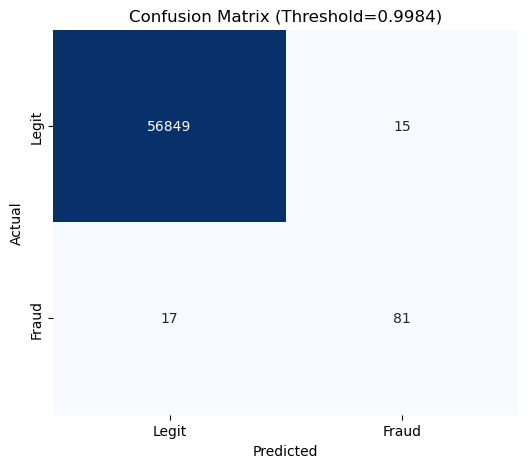

In [7]:
# REPORT NOTE: Standard evaluation (Threshold=0.5) usually yields poor precision 
# in imbalanced datasets. We move the threshold to maximize F1-Score.

# Load Best Weights
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

y_true = []
y_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        logits = model(inputs)
        probs = torch.sigmoid(logits)
        y_true.extend(labels.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# --- Threshold Optimization ---
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\nOptimal Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {f1_scores[best_idx]:.4f}")

# --- Final Metrics ---
y_pred_opt = (np.array(y_probs) > best_threshold).astype(int)
print("\n--- Final Classification Report (Optimized) ---")
print(classification_report(y_true, y_pred_opt, target_names=['Legit', 'Fraud']))

# --- Confusion Matrix Visualization ---
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_true, y_pred_opt, f"Confusion Matrix (Threshold={best_threshold:.4f})")